# Weather Temperature Prediction using LSTM with Station Identification
This notebook demonstrates temperature prediction using LSTM (Long Short-Term Memory) neural networks with Keras, incorporating weather station identifiers (STA) for station-specific analysis.

**Data Source:** Summary of Weather.csv

## 1. Import Required Libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Optional, Dict
import warnings
warnings.filterwarnings('ignore')

# Keras and TensorFlow imports
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load and Explore Data with Station Information

In [32]:
def load_weather_data(file_path: str) -> pd.DataFrame:
    """
    Load weather data from CSV file with station identifiers.
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        DataFrame containing weather data with STA column
    """
    df: pd.DataFrame = pd.read_csv(file_path)
    print(f"✅ Data loaded successfully from {file_path}")
    print(f"📊 Shape: {df.shape}")
    print(f"\n📋 Columns: {df.columns.tolist()}")
    
    # Analyze station information
    if 'STA' in df.columns:
        unique_stations: np.ndarray = df['STA'].unique()
        print(f"\n🏢 Number of unique stations: {len(unique_stations)}")
        print(f"📍 Station IDs: {unique_stations}")
        
        # Show records per station
        station_counts: pd.Series = df['STA'].value_counts().sort_index()
        print(f"\n📊 Records per station:")
        for station, count in station_counts.items():
            print(f"   Station {station}: {count} records")
    
    return df

# Load the Summary of Weather.csv file
file_path: str = 'Summary of Weather.csv'
df: pd.DataFrame = load_weather_data(file_path)

# Display first few rows
print("\n👀 First 5 rows:")
df.head()

✅ Data loaded successfully from Summary of Weather.csv
📊 Shape: (119040, 31)

📋 Columns: ['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']

🏢 Number of unique stations: 159
📍 Station IDs: [10001 10002 10101 10102 10502 10505 10701 10703 10704 10705 10718 10802
 10803 10804 10806 10807 11101 11103 11501 11601 11604 11606 11610 11615
 11701 11704 11801 11901 11902 12001 12101 12701 12702 12706 12801 13002
 13005 13007 13013 13201 13601 15027 16101 16201 16202 16405 16407 16504
 20501 20602 21501 22502 22504 22507 22508 22509 30001 31001 31101 31302
 31401 31501 31701 32301 32501 32503 32504 32601 32602 32603 32701 32702
 32801 32803 32805 32812 32815 32904 32906 32907 33003 33013 33014 33019
 33023 33031 33044 33109 33111 33117 33121 33123 33205 33206 33303 33305
 33307 33401 33405 3

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Data information
print("📊 Data Info:")
print("=" * 70)
df.info()

print("\n📈 Statistical Summary:")
print("=" * 70)
df.describe()

📊 Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  str    
 2   Precip       119040 non-null  str    
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  str    
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 no

,STA,WindGustSpd,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,DR,SPD,...,FT,FB,FTI,ITH,PGT,SD3,RHX,RHN,RVG,WTE
count,119040.000000,532.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,533.000000,532.000000,...,0.0,0.0,0.0,0.0,525.000000,0.0,0.0,0.0,0.0,0.0
mean,29659.435795,37.774534,27.045111,17.789511,22.411631,43.805284,6.726016,15.797530,26.998124,20.396617,...,NaN,NaN,NaN,NaN,12.085333,NaN,NaN,NaN,NaN,NaN
std,20953.209402,10.297808,8.717817,8.334572,8.297982,1.136718,3.425561,8.794541,15.221732,5.560371,...,NaN,NaN,NaN,NaN,5.731328,NaN,NaN,NaN,NaN,NaN
min,10001.000000,18.520000,-33.333333,-38.333333,-35.555556,40.000000,1.000000,1.000000,2.000000,10.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,11801.000000,29.632000,25.555556,15.000000,20.555556,43.000000,4.000000,8.000000,11.000000,16.000000,...,NaN,NaN,NaN,NaN,8.500000,NaN,NaN,NaN,NaN,NaN
50%,22508.000000,37.040000,29.444444,21.111111,25.555556,44.000000,7.000000,16.000000,32.000000,20.000000,...,NaN,NaN,NaN,NaN,11.600000,NaN,NaN,NaN,NaN,NaN
75%,33501.000000,43.059000,31.666667,23.333333,27.222222,45.000000,10.000000,23.000000,34.000000,23.250000,...,NaN,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,NaN,NaN
max,82506.000000,75.932000,50.000000,34.444444,40.000000,45.000000,12.000000,31.000000,78.000000,41.000000,...,NaN,NaN,NaN,NaN,23.900000,NaN,NaN,NaN,NaN,NaN


🔍 Missing Values Analysis:
     Column  Missing Count  Percentage
WindGustSpd         118508       99.55
   Snowfall           1163        0.98
PoorWeather          84803       71.24
       PRCP           1932        1.62
         DR         118507       99.55
        SPD         118508       99.55
        MAX            474        0.40
        MIN            468        0.39
        MEA            498        0.42
        SNF           1163        0.98
        SND         113477       95.33
         FT         119040      100.00
         FB         119040      100.00
        FTI         119040      100.00
        ITH         119040      100.00
        PGT         118515       99.56
 TSHDSBRSGF          84803       71.24
        SD3         119040      100.00
        RHX         119040      100.00
        RHN         119040      100.00
        RVG         119040      100.00
        WTE         119040      100.00


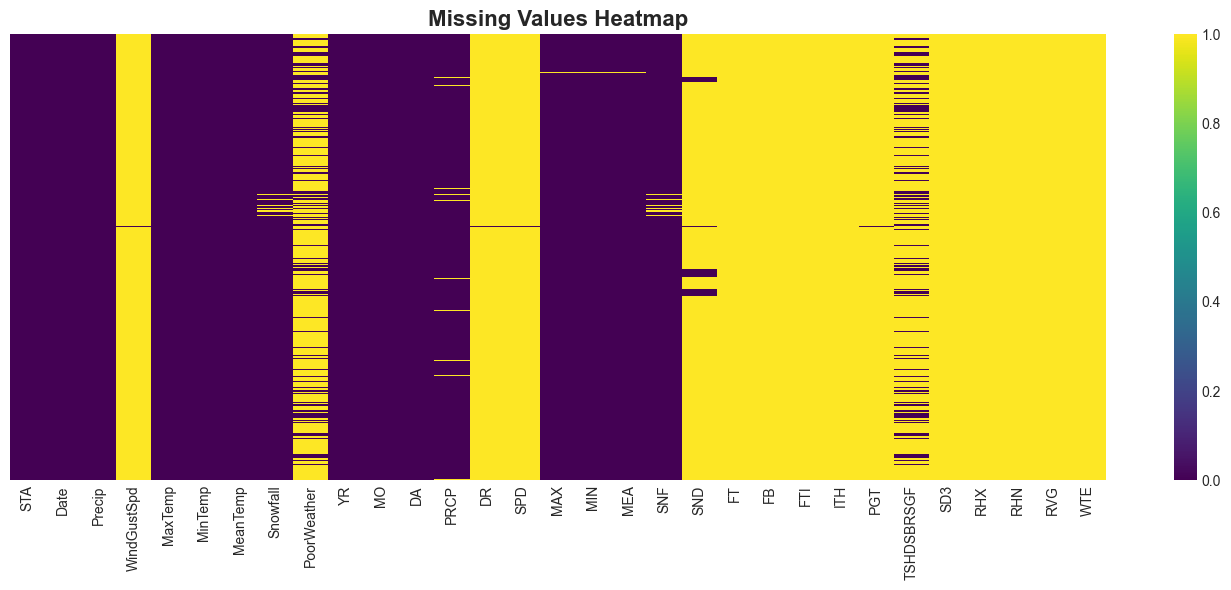

In [34]:
# Check for missing values
print("🔍 Missing Values Analysis:")
print("=" * 70)
missing_values: pd.Series = df.isnull().sum()
missing_df: pd.DataFrame = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Percentage': (missing_values.values / len(df) * 100).round(2)
})
print(missing_df[missing_df['Missing Count'] > 0].to_string(index=False))

# Visualize missing values
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Station Selection and Data Preprocessing

In [35]:
def select_station_data(df: pd.DataFrame, station_id: Optional[int] = None) -> Tuple[pd.DataFrame, int]:
    """
    Select data for a specific station or use the station with most records.
    
    Args:
        df: Input DataFrame with STA column
        station_id: Specific station ID to select (None = auto-select largest)
        
    Returns:
        Tuple of (filtered DataFrame, selected station ID)
    """
    if 'STA' not in df.columns:
        print("⚠️  No STA column found, using all data")
        return df, None
    
    if station_id is None:
        # Select station with most records
        station_counts: pd.Series = df['STA'].value_counts()
        station_id = station_counts.index[0]
        print(f"🎯 Auto-selected Station {station_id} (largest dataset: {station_counts.iloc[0]} records)")
    else:
        print(f"🎯 Selected Station {station_id}")
    
    df_station: pd.DataFrame = df[df['STA'] == station_id].copy()
    print(f"📊 Station {station_id} data shape: {df_station.shape}")
    
    return df_station, station_id

def preprocess_data(df: pd.DataFrame, temperature_column: str = 'MeanTemp') -> pd.DataFrame:
    """
    Preprocess weather data for a specific station.
    
    Args:
        df: Input DataFrame (should be station-specific)
        temperature_column: Name of the temperature column to use for prediction
        
    Returns:
        Preprocessed DataFrame
    """
    df_processed: pd.DataFrame = df.copy()
    
    # Convert Date column to datetime
    if 'Date' in df_processed.columns:
        df_processed['Date'] = pd.to_datetime(df_processed['Date'], errors='coerce')
        df_processed = df_processed.sort_values(by='Date')
        df_processed = df_processed.reset_index(drop=True)
    
    # Handle missing values in temperature column
    if temperature_column in df_processed.columns:
        # Forward fill then backward fill for temperature
        df_processed[temperature_column] = df_processed[temperature_column].ffill().bfill()
        
        # Remove any remaining NaN values
        df_processed = df_processed.dropna(subset=[temperature_column])
    
    print("✅ Data preprocessing completed!")
    print(f"📊 Processed data shape: {df_processed.shape}")
    print(f"🎯 Using '{temperature_column}' for temperature prediction")
    
    return df_processed

# Select station data (auto-select station with most records, or specify station_id)
# To use a specific station, set: df_station, selected_station = select_station_data(df, station_id=10001)
df_station: pd.DataFrame
selected_station: int
df_station, selected_station = select_station_data(df, station_id=None)

# Preprocess data - using MeanTemp as the target variable
df_processed: pd.DataFrame = preprocess_data(df_station, temperature_column='MeanTemp')
df_processed.head()

🎯 Auto-selected Station 22508 (largest dataset: 2192 records)
📊 Station 22508 data shape: (2192, 31)
✅ Data preprocessing completed!
📊 Processed data shape: (2192, 31)
🎯 Using 'MeanTemp' for temperature prediction


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,22508,1940-01-01,0.254,NaN,23.333333,17.222222,20.000000,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22508,1940-01-02,10.16,NaN,23.333333,16.111111,19.444444,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22508,1940-01-03,T,NaN,23.888889,15.555556,20.000000,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22508,1940-01-04,2.286,NaN,23.888889,18.333333,21.111111,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22508,1940-01-05,0.254,NaN,22.222222,15.000000,18.333333,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Exploratory Data Analysis by Station

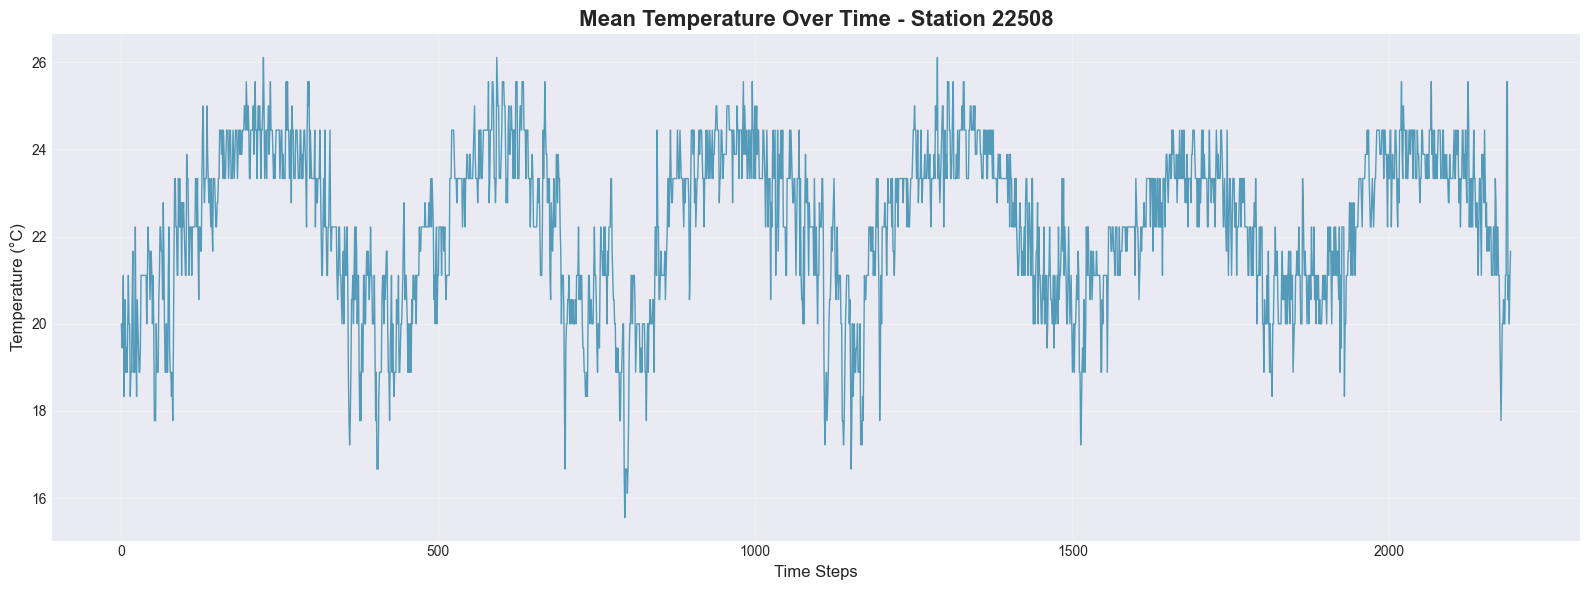

📊 Station 22508 Temperature Statistics:
   Range: 15.56°C to 26.11°C
   Mean: 22.30°C
   Standard deviation: 1.80°C


In [36]:
# Visualize temperature over time for selected station
temperature_col: str = 'MeanTemp'

plt.figure(figsize=(16, 6))
plt.plot(df_processed.index, df_processed[temperature_col], linewidth=1, alpha=0.8, color='#2E86AB')
plt.title(f'Mean Temperature Over Time - Station {selected_station}', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Station {selected_station} Temperature Statistics:")
print(f"   Range: {df_processed[temperature_col].min():.2f}°C to {df_processed[temperature_col].max():.2f}°C")
print(f"   Mean: {df_processed[temperature_col].mean():.2f}°C")
print(f"   Standard deviation: {df_processed[temperature_col].std():.2f}°C")

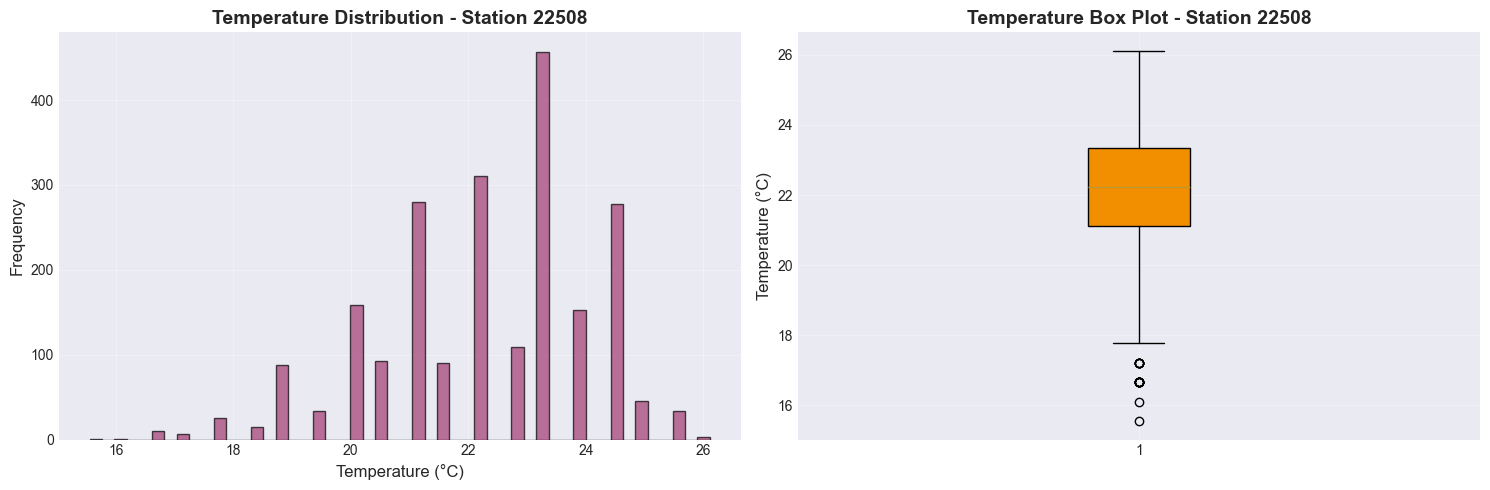

In [37]:
# Distribution of temperature for selected station
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_processed[temperature_col], bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
axes[0].set_title(f'Temperature Distribution - Station {selected_station}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature (°C)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Box plot
bp = axes[1].boxplot(df_processed[temperature_col], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('#F18F01')
axes[1].set_title(f'Temperature Box Plot - Station {selected_station}', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

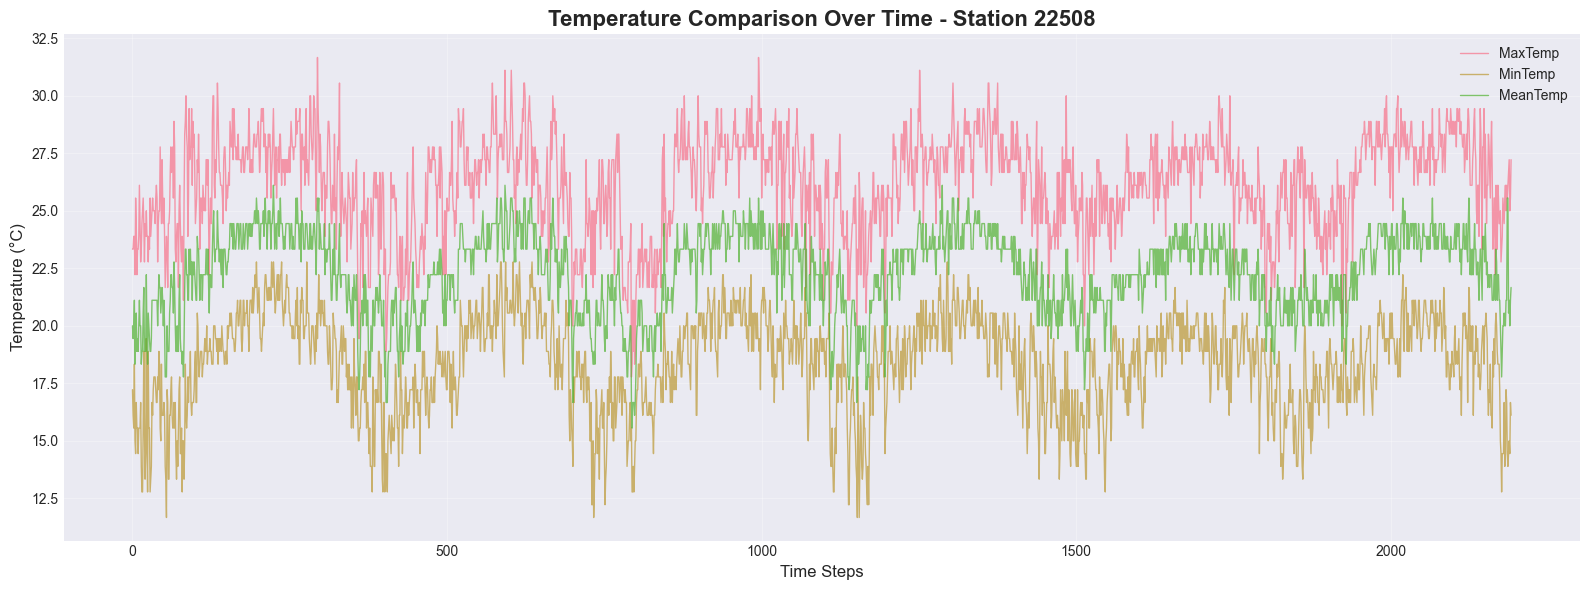

In [38]:
# Analyze temperature columns together for selected station
temp_columns: List[str] = ['MaxTemp', 'MinTemp', 'MeanTemp']
available_temp_cols: List[str] = [col for col in temp_columns if col in df_processed.columns]

if len(available_temp_cols) > 1:
    plt.figure(figsize=(16, 6))
    for col in available_temp_cols:
        plt.plot(df_processed.index, df_processed[col], label=col, linewidth=1, alpha=0.7)
    
    plt.title(f'Temperature Comparison Over Time - Station {selected_station}', fontsize=16, fontweight='bold')
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

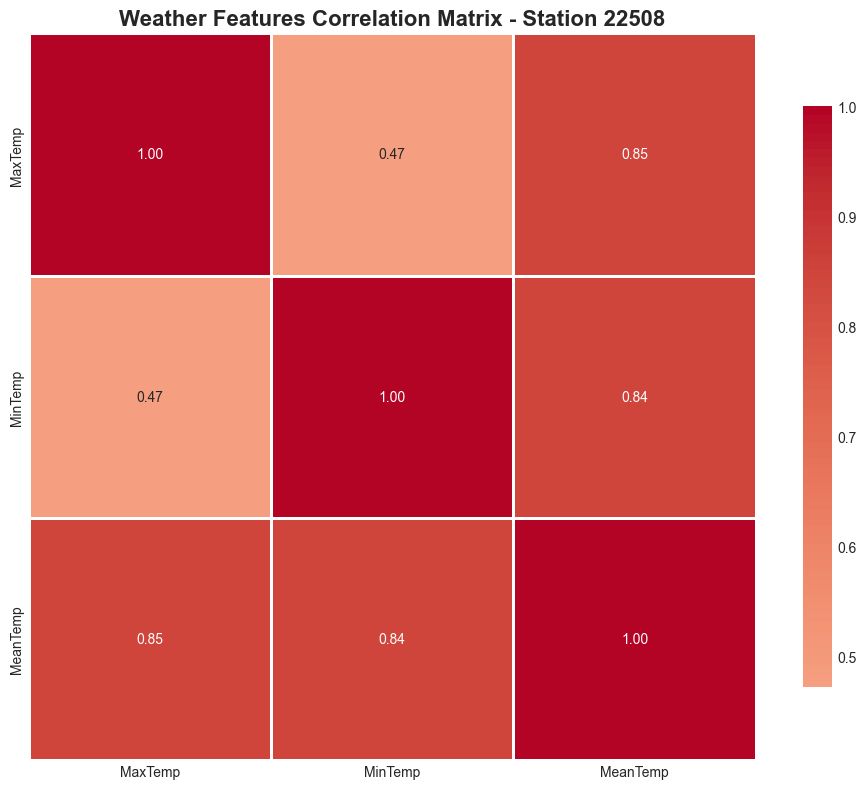

In [39]:
# Correlation matrix for numeric columns of selected station
numeric_cols: List[str] = df_processed.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    # Select key weather features for correlation analysis
    key_features: List[str] = ['Precip', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall']
    available_features: List[str] = [col for col in key_features if col in numeric_cols]
    
    if len(available_features) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix: pd.DataFrame = df_processed[available_features].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title(f'Weather Features Correlation Matrix - Station {selected_station}', 
                  fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

## 5. Prepare Data for LSTM

In [40]:
def create_sequences(data: np.ndarray, lookback: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for LSTM training.
    
    Args:
        data: Input data array (scaled)
        lookback: Number of time steps to look back
        
    Returns:
        Tuple of (X, y) arrays for training
    """
    X: List[np.ndarray] = []
    y: List[float] = []
    
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    
    X_array: np.ndarray = np.array(X)
    y_array: np.ndarray = np.array(y)
    
    # Reshape X for LSTM [samples, time steps, features]
    X_array = np.reshape(X_array, (X_array.shape[0], X_array.shape[1], 1))
    
    return X_array, y_array

# Extract temperature data for selected station
temperature_data: np.ndarray = df_processed[temperature_col].values.reshape(-1, 1)

print(f"📊 Station {selected_station} - Total data points: {len(temperature_data)}")

# Normalize the data
scaler: MinMaxScaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled: np.ndarray = scaler.fit_transform(temperature_data)

print("✅ Data normalized to range [0, 1]")

# Split into train and test sets (80-20 split)
train_size: int = int(len(temperature_scaled) * 0.8)
train_data: np.ndarray = temperature_scaled[:train_size]
test_data: np.ndarray = temperature_scaled[train_size:]

print(f"\n📊 Training data size: {train_size} ({(train_size/len(temperature_scaled)*100):.1f}%)")
print(f"📊 Testing data size: {len(test_data)} ({(len(test_data)/len(temperature_scaled)*100):.1f}%)")

# Create sequences
lookback: int = 60  # Use past 60 time steps to predict next value
print(f"\n🔄 Creating sequences with lookback period: {lookback} days")

X_train: np.ndarray
y_train: np.ndarray
X_train, y_train = create_sequences(train_data, lookback)

X_test: np.ndarray
y_test: np.ndarray
X_test, y_test = create_sequences(test_data, lookback)

print(f"\n✅ Sequences created successfully for Station {selected_station}!")
print(f"📊 X_train shape: {X_train.shape} (samples, time_steps, features)")
print(f"📊 y_train shape: {y_train.shape}")
print(f"📊 X_test shape: {X_test.shape}")
print(f"📊 y_test shape: {y_test.shape}")

📊 Station 22508 - Total data points: 2192
✅ Data normalized to range [0, 1]

📊 Training data size: 1753 (80.0%)
📊 Testing data size: 439 (20.0%)

🔄 Creating sequences with lookback period: 60 days

✅ Sequences created successfully for Station 22508!
📊 X_train shape: (1693, 60, 1) (samples, time_steps, features)
📊 y_train shape: (1693,)
📊 X_test shape: (379, 60, 1)
📊 y_test shape: (379,)


## 6. Build LSTM Model

In [41]:
def build_lstm_model(input_shape: Tuple[int, int], 
                     lstm_units: List[int] = [50, 50],
                     dropout_rate: float = 0.2) -> Sequential:
    """
    Build LSTM model for temperature prediction.
    
    Args:
        input_shape: Shape of input data (time steps, features)
        lstm_units: List of units for each LSTM layer
        dropout_rate: Dropout rate for regularization
        
    Returns:
        Compiled Keras Sequential model
    """
    model: Sequential = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=lstm_units[0], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer
    model.add(LSTM(units=lstm_units[1], return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

# Build the model
print(f"🏗️  Building LSTM model for Station {selected_station}...")
model: Sequential = build_lstm_model(
    input_shape=(X_train.shape[1], 1),
    lstm_units=[50, 50],
    dropout_rate=0.2
)

print("\n📋 Model Architecture:")
print("=" * 70)
model.summary()
print("=" * 70)
print("✅ Model built successfully!")

🏗️  Building LSTM model for Station 22508...

📋 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

✅ Model built successfully!


## 7. Train the Model

In [42]:
# Define callbacks
early_stopping: EarlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint: ModelCheckpoint = ModelCheckpoint(
    f'best_lstm_model_station_{selected_station}.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
print(f"🚀 Training the model for Station {selected_station}...")
print("=" * 70)
history: keras.callbacks.History = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\n" + "=" * 70)
print("✅ Training completed!")
print(f"📊 Total epochs trained: {len(history.history['loss'])}")
print(f"📊 Final training loss: {history.history['loss'][-1]:.6f}")
print(f"📊 Final validation loss: {history.history['val_loss'][-1]:.6f}")

🚀 Training the model for Station 22508...
Epoch 1/100


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1481 - mae: 0.2983
Epoch 1: val_loss improved from None to 0.00767, saving model to best_lstm_model_station_22508.h5



Epoch 1: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0637 - mae: 0.1826 - val_loss: 0.0077 - val_mae: 0.0688
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0184 - mae: 0.1046
Epoch 2: val_loss improved from 0.00767 to 0.00744, saving model to best_lstm_model_station_22508.h5



Epoch 2: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0177 - mae: 0.1029 - val_loss: 0.0074 - val_mae: 0.0647
Epoch 3/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0154 - mae: 0.0974
Epoch 3: val_loss improved from 0.00744 to 0.00715, saving model to best_lstm_model_station_22508.h5



Epoch 3: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0158 - mae: 0.0977 - val_loss: 0.0072 - val_mae: 0.0660
Epoch 4/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0159 - mae: 0.0982
Epoch 4: val_loss did not improve from 0.00715
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0160 - mae: 0.0982 - val_loss: 0.0072 - val_mae: 0.0669
Epoch 5/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144 - mae: 0.0936
Epoch 5: val_loss did not improve from 0.00715
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0150 - mae: 0.0967 - val_loss: 0.0072 - val_mae: 0.0674
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0145 - mae: 0.0930
Epoch 6: val_loss improved from 0.00715 to 0.00703, saving model to best_lstm_model_station_22508.h5



Epoch 6: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0148 - mae: 0.0949 - val_loss: 0.0070 - val_mae: 0.0659
Epoch 7/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0156 - mae: 0.0967
Epoch 7: val_loss improved from 0.00703 to 0.00678, saving model to best_lstm_model_station_22508.h5



Epoch 7: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0152 - mae: 0.0956 - val_loss: 0.0068 - val_mae: 0.0637
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0138 - mae: 0.0921
Epoch 8: val_loss did not improve from 0.00678
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0141 - mae: 0.0926 - val_loss: 0.0068 - val_mae: 0.0646
Epoch 9/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0142 - mae: 0.0923
Epoch 9: val_loss did not improve from 0.00678
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0140 - mae: 0.0918 - val_loss: 0.0068 - val_mae: 0.0649
Epoch 10/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0140 - mae: 0.0925
Epoch 10: val_loss did not improve from 0.00678
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0141 - mae: 0.0936 - val_loss: 0.0072 - val_mae: 0.0678
Epoch 11/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0134 - mae: 0.0895
Epoch 11: val_loss did not improve from 


Epoch 12: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0134 - mae: 0.0908 - val_loss: 0.0068 - val_mae: 0.0649
Epoch 13/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0136 - mae: 0.0903
Epoch 13: val_loss improved from 0.00678 to 0.00644, saving model to best_lstm_model_station_22508.h5



Epoch 13: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0130 - mae: 0.0887 - val_loss: 0.0064 - val_mae: 0.0621
Epoch 14/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0133 - mae: 0.0899
Epoch 14: val_loss did not improve from 0.00644
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0130 - mae: 0.0885 - val_loss: 0.0068 - val_mae: 0.0656
Epoch 15/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0131 - mae: 0.0893
Epoch 15: val_loss did not improve from 0.00644
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0131 - mae: 0.0895 - val_loss: 0.0065 - val_mae: 0.0632
Epoch 16/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0131 - mae: 0.0881
Epoch 16: val_loss did not improve from 0.00644
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0129 - mae: 0.0883 - val_loss: 0.0068 - val_mae: 0.0657
Epoch 17/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0127 - mae: 0.0875
Epoch 17: val_loss improved from 0.


Epoch 17: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0123 - mae: 0.0865 - val_loss: 0.0062 - val_mae: 0.0599
Epoch 18/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0123 - mae: 0.0852
Epoch 18: val_loss did not improve from 0.00623
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0122 - mae: 0.0859 - val_loss: 0.0074 - val_mae: 0.0699
Epoch 19/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127 - mae: 0.0880
Epoch 19: val_loss did not improve from 0.00623
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0123 - mae: 0.0863 - val_loss: 0.0065 - val_mae: 0.0641
Epoch 20/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0123 - mae: 0.0878
Epoch 20: val_loss did not improve from 0.00623
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0121 - mae: 0.0858 - val_loss: 0.0070 - val_mae: 0.0675
Epoch 21/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0125 - mae: 0.0874
Epoch 21: val_loss did not improve 


Epoch 23: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0114 - mae: 0.0834 - val_loss: 0.0061 - val_mae: 0.0607
Epoch 24/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - mae: 0.0791
Epoch 24: val_loss did not improve from 0.00609
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0108 - mae: 0.0794 - val_loss: 0.0061 - val_mae: 0.0608
Epoch 25/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - mae: 0.0814
Epoch 25: val_loss did not improve from 0.00609
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0107 - mae: 0.0802 - val_loss: 0.0063 - val_mae: 0.0630
Epoch 26/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106 - mae: 0.0806
Epoch 26: val_loss improved from 0.00609 to 0.00587, saving model to best_lstm_model_station_22508.h5



Epoch 26: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0104 - mae: 0.0802 - val_loss: 0.0059 - val_mae: 0.0590
Epoch 27/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106 - mae: 0.0801
Epoch 27: val_loss did not improve from 0.00587
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0106 - mae: 0.0805 - val_loss: 0.0069 - val_mae: 0.0672
Epoch 28/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - mae: 0.0813
Epoch 28: val_loss did not improve from 0.00587
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0104 - mae: 0.0803 - val_loss: 0.0062 - val_mae: 0.0618
Epoch 29/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107 - mae: 0.0797
Epoch 29: val_loss did not improve from 0.00587
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0106 - mae: 0.0800 - val_loss: 0.0064 - val_mae: 0.0635
Epoch 30/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0105 - mae: 0.0800
Epoch 30: val_loss did not improve 


Epoch 35: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0103 - mae: 0.0797 - val_loss: 0.0057 - val_mae: 0.0579
Epoch 36/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0095 - mae: 0.0756
Epoch 36: val_loss did not improve from 0.00572
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0099 - mae: 0.0783 - val_loss: 0.0058 - val_mae: 0.0592
Epoch 37/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0093 - mae: 0.0752
Epoch 37: val_loss did not improve from 0.00572
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0096 - mae: 0.0765 - val_loss: 0.0060 - val_mae: 0.0609
Epoch 38/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098 - mae: 0.0780
Epoch 38: val_loss improved from 0.00572 to 0.00569, saving model to best_lstm_model_station_22508.h5



Epoch 38: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095 - mae: 0.0772 - val_loss: 0.0057 - val_mae: 0.0582
Epoch 39/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0093 - mae: 0.0749
Epoch 39: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0091 - mae: 0.0742 - val_loss: 0.0058 - val_mae: 0.0598
Epoch 40/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0092 - mae: 0.0743
Epoch 40: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0093 - mae: 0.0746 - val_loss: 0.0057 - val_mae: 0.0579
Epoch 41/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0094 - mae: 0.0757
Epoch 41: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0092 - mae: 0.0755 - val_loss: 0.0059 - val_mae: 0.0607
Epoch 42/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0091 - mae: 0.0736
Epoch 42: val_loss did not improve 


Epoch 48: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0092 - mae: 0.0755 - val_loss: 0.0057 - val_mae: 0.0578
Epoch 49/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - mae: 0.0740
Epoch 49: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0088 - mae: 0.0738 - val_loss: 0.0058 - val_mae: 0.0596
Epoch 50/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0096 - mae: 0.0756
Epoch 50: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0092 - mae: 0.0743 - val_loss: 0.0057 - val_mae: 0.0590
Epoch 51/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0089 - mae: 0.0734
Epoch 51: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0090 - mae: 0.0748 - val_loss: 0.0059 - val_mae: 0.0601
Epoch 52/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - mae: 0.0727
Epoch 52: val_loss did not improve 


Epoch 53: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0083 - mae: 0.0707 - val_loss: 0.0057 - val_mae: 0.0583
Epoch 54/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0087 - mae: 0.0720
Epoch 54: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0084 - mae: 0.0716 - val_loss: 0.0057 - val_mae: 0.0588
Epoch 55/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0085 - mae: 0.0704
Epoch 55: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0084 - mae: 0.0703 - val_loss: 0.0058 - val_mae: 0.0597
Epoch 56/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085 - mae: 0.0730
Epoch 56: val_loss did not improve from 0.00569
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0082 - mae: 0.0710 - val_loss: 0.0059 - val_mae: 0.0606
Epoch 57/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - mae: 0.0723
Epoch 57: val_loss did not improve 


Epoch 58: finished saving model to best_lstm_model_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0088 - mae: 0.0734 - val_loss: 0.0057 - val_mae: 0.0581
Epoch 59/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - mae: 0.0725
Epoch 59: val_loss did not improve from 0.00567
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0087 - mae: 0.0726 - val_loss: 0.0057 - val_mae: 0.0585
Epoch 60/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - mae: 0.0689
Epoch 60: val_loss did not improve from 0.00567
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0083 - mae: 0.0700 - val_loss: 0.0057 - val_mae: 0.0588
Epoch 61/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0091 - mae: 0.0746
Epoch 61: val_loss did not improve from 0.00567
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0087 - mae: 0.0732 - val_loss: 0.0057 - val_mae: 0.0579
Epoch 62/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - mae: 0.0723
Epoch 62: val_loss did not improve 

## 8. Visualize Training History

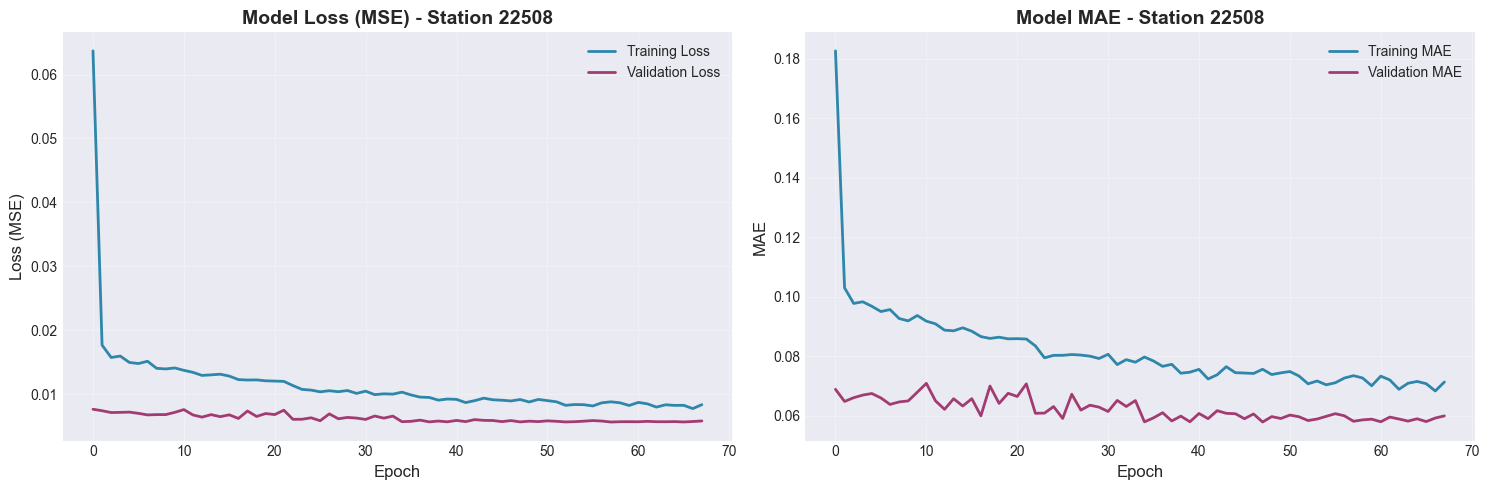

In [43]:
def plot_training_history(history: keras.callbacks.History, station_id: int) -> None:
    """
    Plot training and validation loss/metrics.
    
    Args:
        history: Keras training history object
        station_id: Station identifier for title
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
    axes[0].set_title(f'Model Loss (MSE) - Station {station_id}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot MAE
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, color='#2E86AB')
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='#A23B72')
    axes[1].set_title(f'Model MAE - Station {station_id}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, selected_station)

## 9. Make Predictions

In [44]:
# Make predictions
print(f"🔮 Making predictions for Station {selected_station}...")
train_predictions: np.ndarray = model.predict(X_train, verbose=0)
test_predictions: np.ndarray = model.predict(X_test, verbose=0)

# Inverse transform predictions to original scale
train_predictions_original: np.ndarray = scaler.inverse_transform(train_predictions)
test_predictions_original: np.ndarray = scaler.inverse_transform(test_predictions)
y_train_original: np.ndarray = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original: np.ndarray = scaler.inverse_transform(y_test.reshape(-1, 1))

print("✅ Predictions completed and inverse transformed to original scale!")

🔮 Making predictions for Station 22508...


✅ Predictions completed and inverse transformed to original scale!


## 10. Calculate Performance Metrics

In [45]:
def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calculate performance metrics.
    
    Args:
        y_true: True values
        y_pred: Predicted values
        
    Returns:
        Dictionary containing performance metrics
    """
    mse: float = mean_squared_error(y_true, y_pred)
    rmse: float = np.sqrt(mse)
    mae: float = mean_absolute_error(y_true, y_pred)
    r2: float = r2_score(y_true, y_pred)
    
    metrics: Dict[str, float] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    }
    
    return metrics

# Calculate metrics for training set
train_metrics: Dict[str, float] = calculate_metrics(y_train_original, train_predictions_original)
print(f"\n📊 Training Set Metrics - Station {selected_station}:")
print("=" * 70)
for metric, value in train_metrics.items():
    print(f"  {metric:15s}: {value:.6f}")

print("\n" + "=" * 70 + "\n")

# Calculate metrics for test set
test_metrics: Dict[str, float] = calculate_metrics(y_test_original, test_predictions_original)
print(f"🎯 Test Set Metrics - Station {selected_station}:")
print("=" * 70)
for metric, value in test_metrics.items():
    print(f"  {metric:15s}: {value:.6f}")

print("\n" + "=" * 70)


📊 Training Set Metrics - Station 22508:
  MSE            : 0.715536
  RMSE           : 0.845894
  MAE            : 0.646300
  R2 Score       : 0.785964


🎯 Test Set Metrics - Station 22508:
  MSE            : 0.700513
  RMSE           : 0.836967
  MAE            : 0.636601
  R2 Score       : 0.716972



## 11. Visualize Predictions

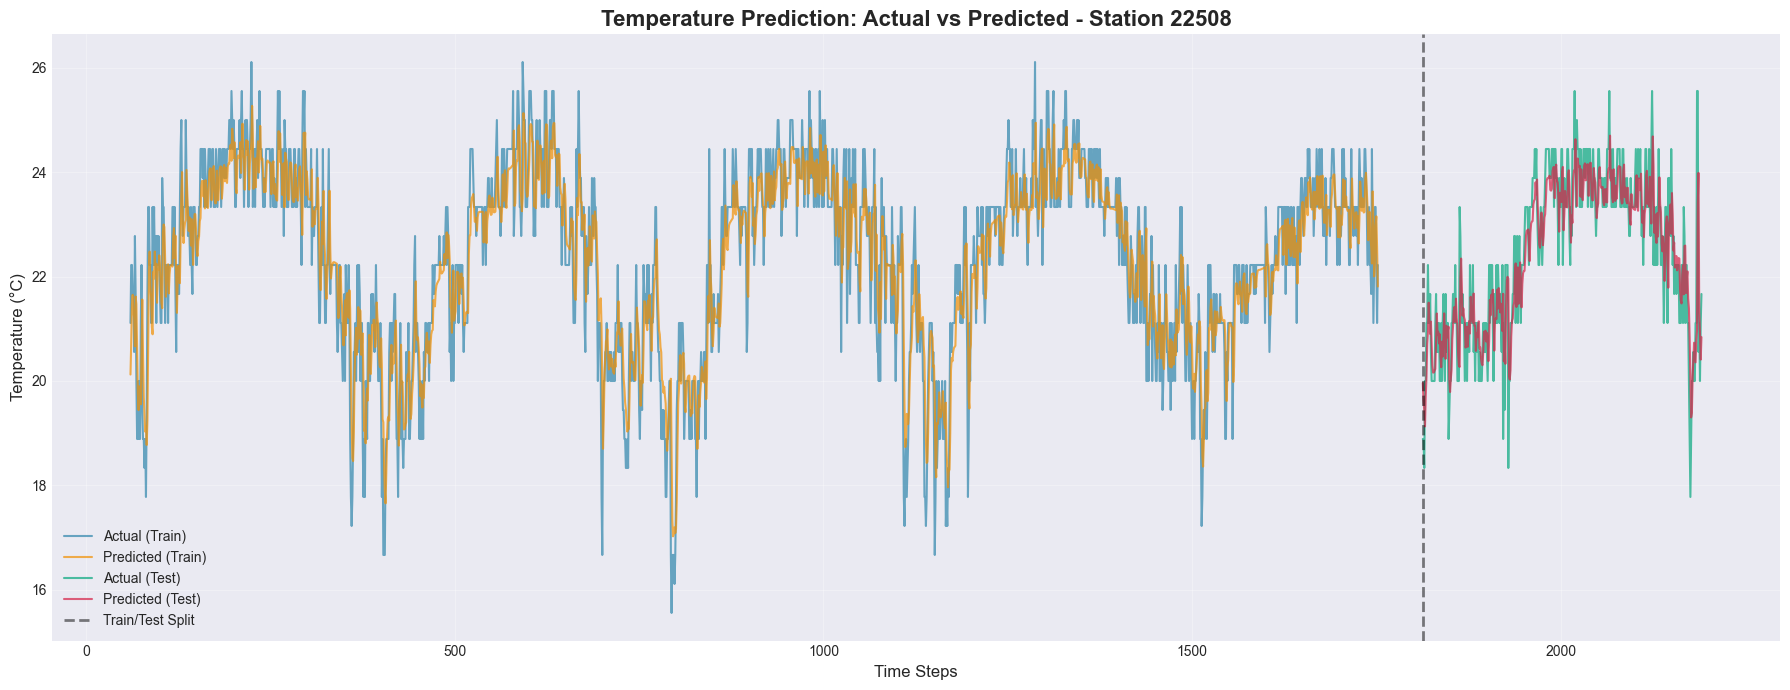

In [46]:
# Plot predictions vs actual values
plt.figure(figsize=(18, 7))

# Training data
train_plot_x: np.ndarray = np.arange(lookback, lookback + len(train_predictions_original))
plt.plot(train_plot_x, y_train_original, label='Actual (Train)', 
         color='#2E86AB', alpha=0.7, linewidth=1.5)
plt.plot(train_plot_x, train_predictions_original, label='Predicted (Train)', 
         color='#F18F01', alpha=0.7, linewidth=1.5)

# Test data
test_plot_x: np.ndarray = np.arange(train_size + lookback, train_size + lookback + len(test_predictions_original))
plt.plot(test_plot_x, y_test_original, label='Actual (Test)', 
         color='#06A77D', alpha=0.7, linewidth=1.5)
plt.plot(test_plot_x, test_predictions_original, label='Predicted (Test)', 
         color='#D62246', alpha=0.7, linewidth=1.5)

# Add vertical line to separate train and test
plt.axvline(x=train_size + lookback, color='black', linestyle='--', 
            linewidth=2, label='Train/Test Split', alpha=0.5)

plt.title(f'Temperature Prediction: Actual vs Predicted - Station {selected_station}', 
          fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

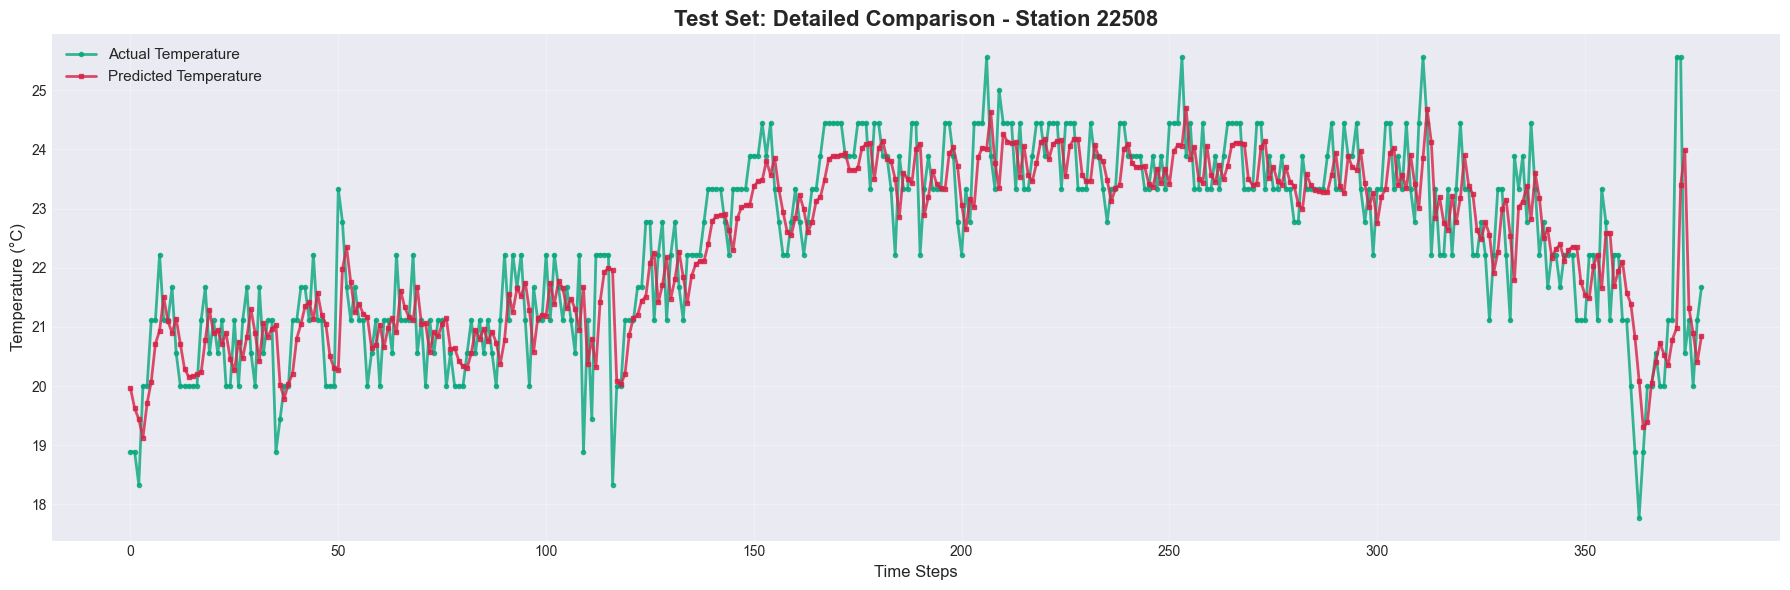

In [47]:
# Zoom in on test predictions
plt.figure(figsize=(18, 6))
plt.plot(y_test_original, label='Actual Temperature', 
         color='#06A77D', linewidth=2, marker='o', markersize=3, alpha=0.8)
plt.plot(test_predictions_original, label='Predicted Temperature', 
         color='#D62246', linewidth=2, marker='s', markersize=3, alpha=0.8)
plt.title(f'Test Set: Detailed Comparison - Station {selected_station}', 
          fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

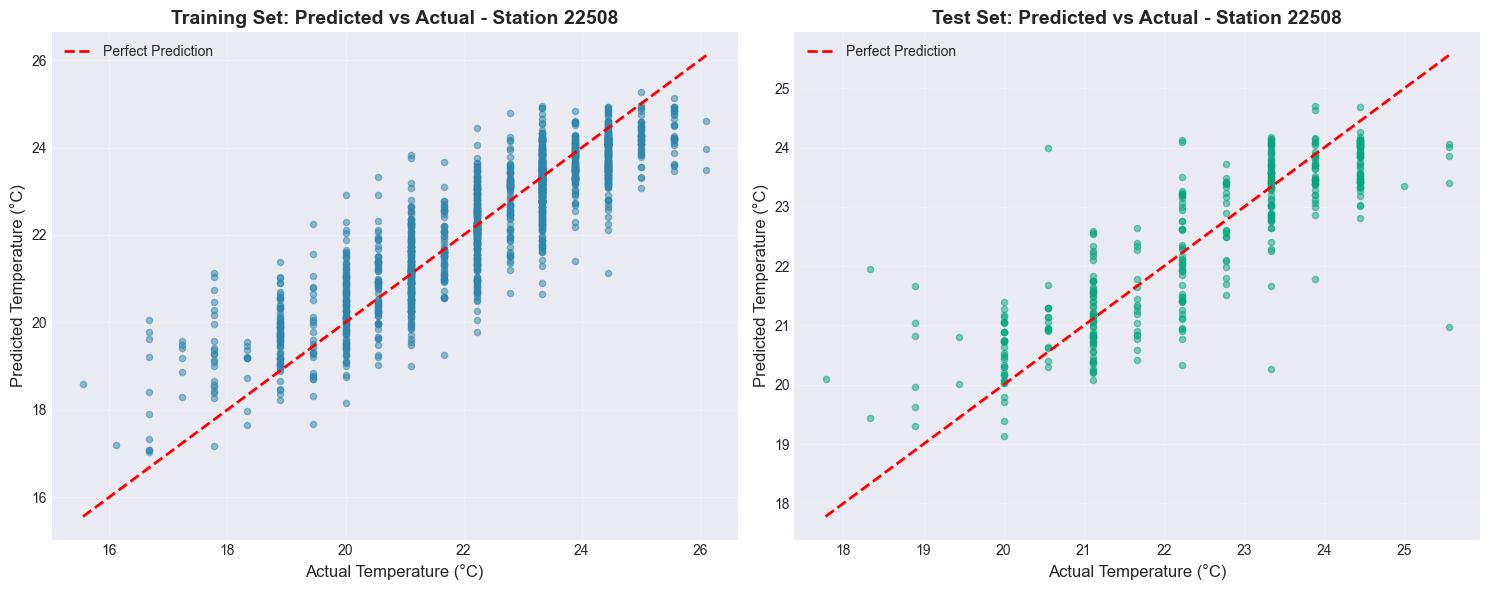

In [48]:
# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train_original, train_predictions_original, alpha=0.5, s=20, color='#2E86AB')
axes[0].plot([y_train_original.min(), y_train_original.max()], 
             [y_train_original.min(), y_train_original.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title(f'Training Set: Predicted vs Actual - Station {selected_station}', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Temperature (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Temperature (°C)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test_original, test_predictions_original, alpha=0.5, s=20, color='#06A77D')
axes[1].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title(f'Test Set: Predicted vs Actual - Station {selected_station}', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Predicted Temperature (°C)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Residual Analysis

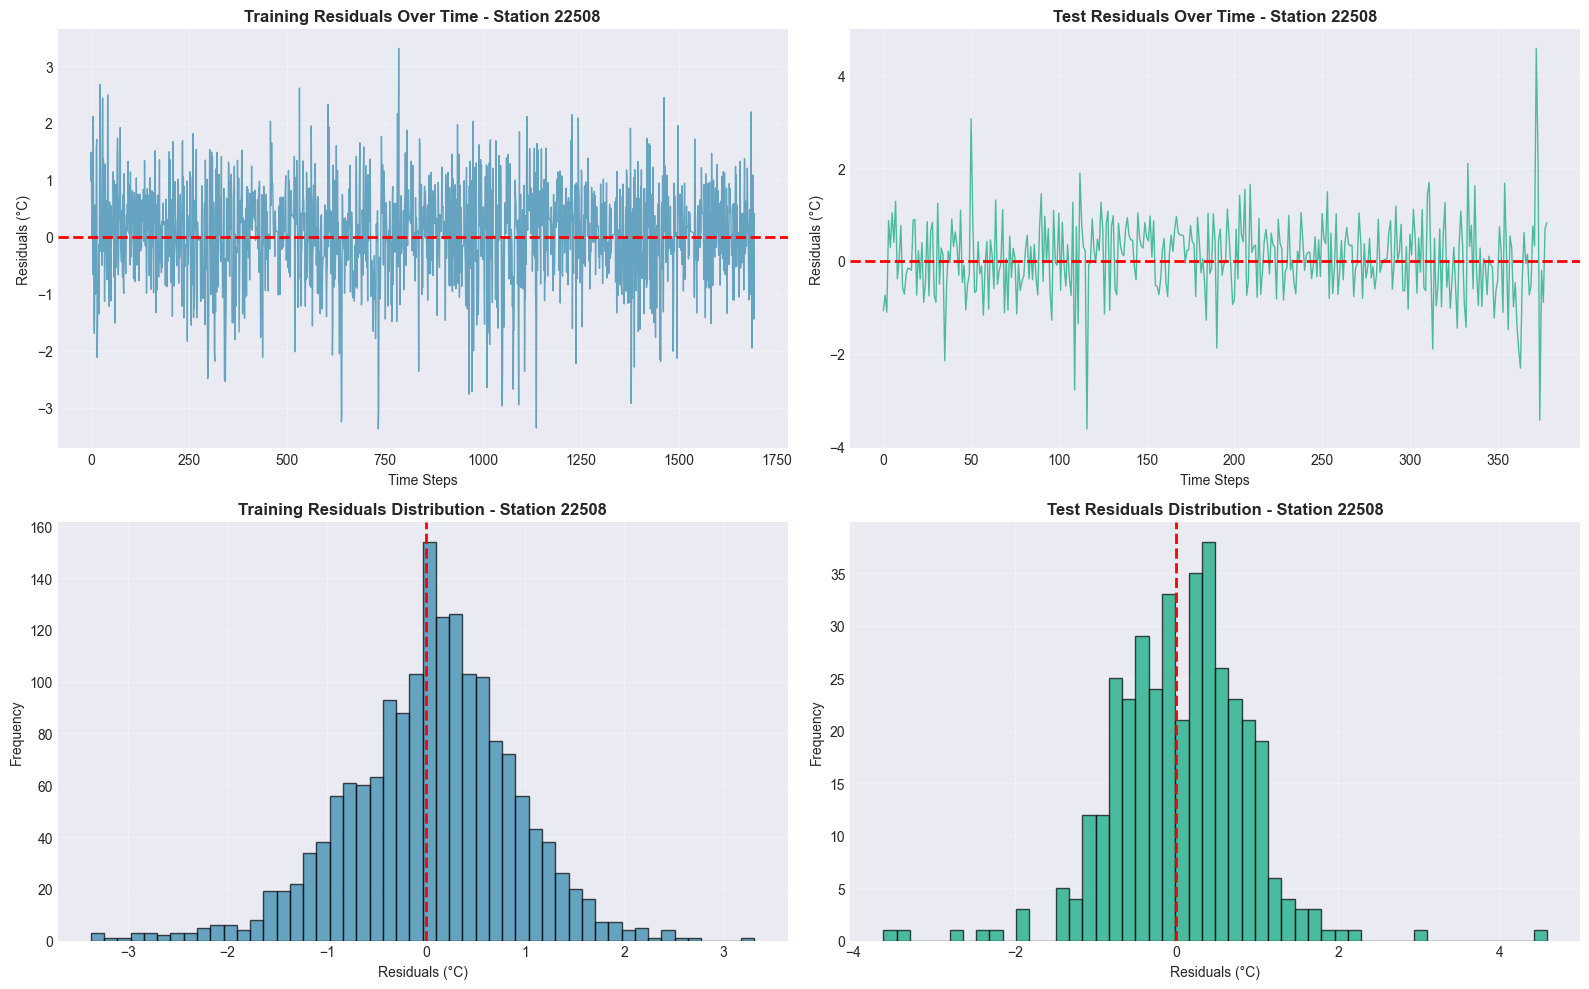


📊 Station 22508 - Training Residuals: Mean=0.0460°C, Std=0.8446°C
📊 Station 22508 - Test Residuals: Mean=0.0551°C, Std=0.8352°C


In [49]:
# Calculate residuals
train_residuals: np.ndarray = y_train_original - train_predictions_original
test_residuals: np.ndarray = y_test_original - test_predictions_original

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training residuals over time
axes[0, 0].plot(train_residuals, color='#2E86AB', alpha=0.7, linewidth=1)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_title(f'Training Residuals Over Time - Station {selected_station}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time Steps', fontsize=10)
axes[0, 0].set_ylabel('Residuals (°C)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Test residuals over time
axes[0, 1].plot(test_residuals, color='#06A77D', alpha=0.7, linewidth=1)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_title(f'Test Residuals Over Time - Station {selected_station}', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time Steps', fontsize=10)
axes[0, 1].set_ylabel('Residuals (°C)', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Training residuals distribution
axes[1, 0].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title(f'Training Residuals Distribution - Station {selected_station}', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residuals (°C)', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Test residuals distribution
axes[1, 1].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='#06A77D')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title(f'Test Residuals Distribution - Station {selected_station}', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residuals (°C)', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Station {selected_station} - Training Residuals: Mean={train_residuals.mean():.4f}°C, Std={train_residuals.std():.4f}°C")
print(f"📊 Station {selected_station} - Test Residuals: Mean={test_residuals.mean():.4f}°C, Std={test_residuals.std():.4f}°C")

## 13. Error Distribution Analysis

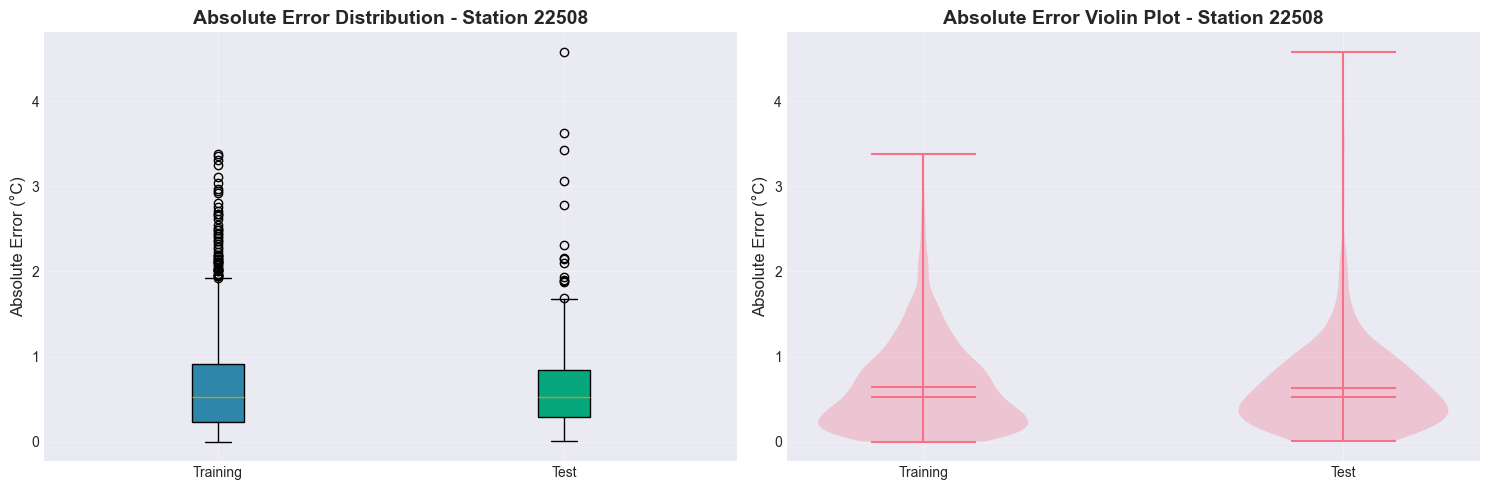


📊 Station 22508 - Training Absolute Error: Mean=0.6463°C, Median=0.5220°C
📊 Station 22508 - Test Absolute Error: Mean=0.6366°C, Median=0.5264°C


In [50]:
# Calculate absolute errors
train_abs_errors: np.ndarray = np.abs(train_residuals)
test_abs_errors: np.ndarray = np.abs(test_residuals)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot comparison
bp = axes[0].boxplot([train_abs_errors.flatten(), test_abs_errors.flatten()],
                      labels=['Training', 'Test'],
                      patch_artist=True)
bp['boxes'][0].set_facecolor('#2E86AB')
bp['boxes'][1].set_facecolor('#06A77D')
axes[0].set_title(f'Absolute Error Distribution - Station {selected_station}', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Absolute Error (°C)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Violin plot
data_to_plot: List[np.ndarray] = [train_abs_errors.flatten(), test_abs_errors.flatten()]
positions: List[int] = [1, 2]
parts = axes[1].violinplot(data_to_plot, positions=positions, showmeans=True, showmedians=True)
axes[1].set_xticks(positions)
axes[1].set_xticklabels(['Training', 'Test'])
axes[1].set_title(f'Absolute Error Violin Plot - Station {selected_station}', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Absolute Error (°C)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Station {selected_station} - Training Absolute Error: Mean={train_abs_errors.mean():.4f}°C, Median={np.median(train_abs_errors):.4f}°C")
print(f"📊 Station {selected_station} - Test Absolute Error: Mean={test_abs_errors.mean():.4f}°C, Median={np.median(test_abs_errors):.4f}°C")

## 14. Summary Report

In [51]:
def print_summary_report(train_metrics: Dict[str, float], test_metrics: Dict[str, float], 
                        station_id: int) -> None:
    """
    Print comprehensive summary report for specific station.
    
    Args:
        train_metrics: Training set metrics
        test_metrics: Test set metrics
        station_id: Station identifier
    """
    print("\n" + "="*80)
    print(" " * 15 + f"🌡️  LSTM TEMPERATURE PREDICTION - STATION {station_id}")
    print("="*80)
    
    print("\n📊 MODEL CONFIGURATION:")
    print("-" * 80)
    print("  • Data Source: Summary of Weather.csv")
    print(f"  • Station ID: {station_id}")
    print("  • Target Variable: MeanTemp (Mean Temperature)")
    print(f"  • Lookback Period: {lookback} time steps (days)")
    print(f"  • Training Samples: {len(X_train)}")
    print(f"  • Test Samples: {len(X_test)}")
    print(f"  • Total Epochs: {len(history.history['loss'])}")
    print("  • LSTM Architecture: 2 layers with 50 units each")
    print("  • Dropout Rate: 0.2")
    
    print("\n📈 TRAINING SET PERFORMANCE:")
    print("-" * 80)
    for metric, value in train_metrics.items():
        print(f"  • {metric:15s}: {value:.6f}")
    
    print("\n🎯 TEST SET PERFORMANCE:")
    print("-" * 80)
    for metric, value in test_metrics.items():
        print(f"  • {metric:15s}: {value:.6f}")
    
    print("\n💡 MODEL INSIGHTS:")
    print("-" * 80)
    
    # Calculate percentage errors
    train_mape: float = np.mean(np.abs((y_train_original - train_predictions_original) / y_train_original)) * 100
    test_mape: float = np.mean(np.abs((y_test_original - test_predictions_original) / y_test_original)) * 100
    
    print(f"  • Training MAPE: {train_mape:.2f}%")
    print(f"  • Test MAPE: {test_mape:.2f}%")
    print(f"  • Model explains {test_metrics['R2 Score']*100:.2f}% of variance in test data")
    print(f"  • Average prediction error on test set: {test_metrics['MAE']:.4f}°C")
    
    print("\n🏆 PERFORMANCE EVALUATION:")
    print("-" * 80)
    if test_metrics['R2 Score'] > 0.9:
        print(f"  ✅ Excellent model performance for Station {station_id}!")
        print("     The model captures temperature patterns very well.")
    elif test_metrics['R2 Score'] > 0.7:
        print(f"  ✅ Good model performance for Station {station_id}!")
        print("     The model shows strong predictive capability.")
    elif test_metrics['R2 Score'] > 0.5:
        print(f"  ⚠️  Moderate model performance for Station {station_id}.")
        print("     Consider tuning hyperparameters or adding features.")
    else:
        print(f"  ⚠️  Poor model performance for Station {station_id}.")
        print("     Consider feature engineering or model redesign.")
    
    print("\n" + "="*80 + "\n")

print_summary_report(train_metrics, test_metrics, selected_station)


               🌡️  LSTM TEMPERATURE PREDICTION - STATION 22508

📊 MODEL CONFIGURATION:
--------------------------------------------------------------------------------
  • Data Source: Summary of Weather.csv
  • Station ID: 22508
  • Target Variable: MeanTemp (Mean Temperature)
  • Lookback Period: 60 time steps (days)
  • Training Samples: 1693
  • Test Samples: 379
  • Total Epochs: 68
  • LSTM Architecture: 2 layers with 50 units each
  • Dropout Rate: 0.2

📈 TRAINING SET PERFORMANCE:
--------------------------------------------------------------------------------
  • MSE            : 0.715536
  • RMSE           : 0.845894
  • MAE            : 0.646300
  • R2 Score       : 0.785964

🎯 TEST SET PERFORMANCE:
--------------------------------------------------------------------------------
  • MSE            : 0.700513
  • RMSE           : 0.836967
  • MAE            : 0.636601
  • R2 Score       : 0.716972

💡 MODEL INSIGHTS:
------------------------------------------------------------

## 15. Save Model and Results

In [52]:
import json

# Save the final model
model_filename: str = f'lstm_temperature_model_station_{selected_station}.h5'
model.save(model_filename)
print(f"✅ Model saved as '{model_filename}'")

# Save predictions to CSV
predictions_df: pd.DataFrame = pd.DataFrame({
    'Station_ID': [selected_station] * len(y_test_original),
    'Actual_Test': y_test_original.flatten(),
    'Predicted_Test': test_predictions_original.flatten(),
    'Residuals': test_residuals.flatten(),
    'Absolute_Error': test_abs_errors.flatten()
})

predictions_filename: str = f'temperature_predictions_station_{selected_station}.csv'
predictions_df.to_csv(predictions_filename, index=False)
print(f"✅ Predictions saved as '{predictions_filename}'")

# Save metrics to JSON
metrics_summary: Dict[str, any] = {
    'data_source': 'Summary of Weather.csv',
    'station_id': int(selected_station),
    'target_variable': 'MeanTemp',
    'training_metrics': {k: float(v) for k, v in train_metrics.items()},
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'model_config': {
        'lookback': lookback,
        'lstm_units': [50, 50],
        'dropout_rate': 0.2,
        'epochs_trained': len(history.history['loss']),
        'batch_size': 32,
        'optimizer': 'adam',
        'loss_function': 'mean_squared_error'
    },
    'data_split': {
        'train_size': len(X_train),
        'test_size': len(X_test),
        'train_percentage': 80,
        'test_percentage': 20
    }
}

metrics_filename: str = f'model_metrics_station_{selected_station}.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics_summary, f, indent=4)

print(f"✅ Metrics saved as '{metrics_filename}'")
print("\n🎉 All results saved successfully!")
print(f"\n📁 Generated Files for Station {selected_station}:")
print(f"  • {model_filename} - Trained LSTM model")
print(f"  • best_lstm_model_station_{selected_station}.h5 - Best model checkpoint")
print(f"  • {predictions_filename} - Test predictions and errors")
print(f"  • {metrics_filename} - Comprehensive metrics and configuration")

✅ Model saved as 'lstm_temperature_model_station_22508.h5'
✅ Predictions saved as 'temperature_predictions_station_22508.csv'
✅ Metrics saved as 'model_metrics_station_22508.json'

🎉 All results saved successfully!

📁 Generated Files for Station 22508:
  • lstm_temperature_model_station_22508.h5 - Trained LSTM model
  • best_lstm_model_station_22508.h5 - Best model checkpoint
  • temperature_predictions_station_22508.csv - Test predictions and errors
  • model_metrics_station_22508.json - Comprehensive metrics and configuration


## 16. Future Predictions (Optional)

🔮 Generating 30 days of future temperature predictions for Station 22508...


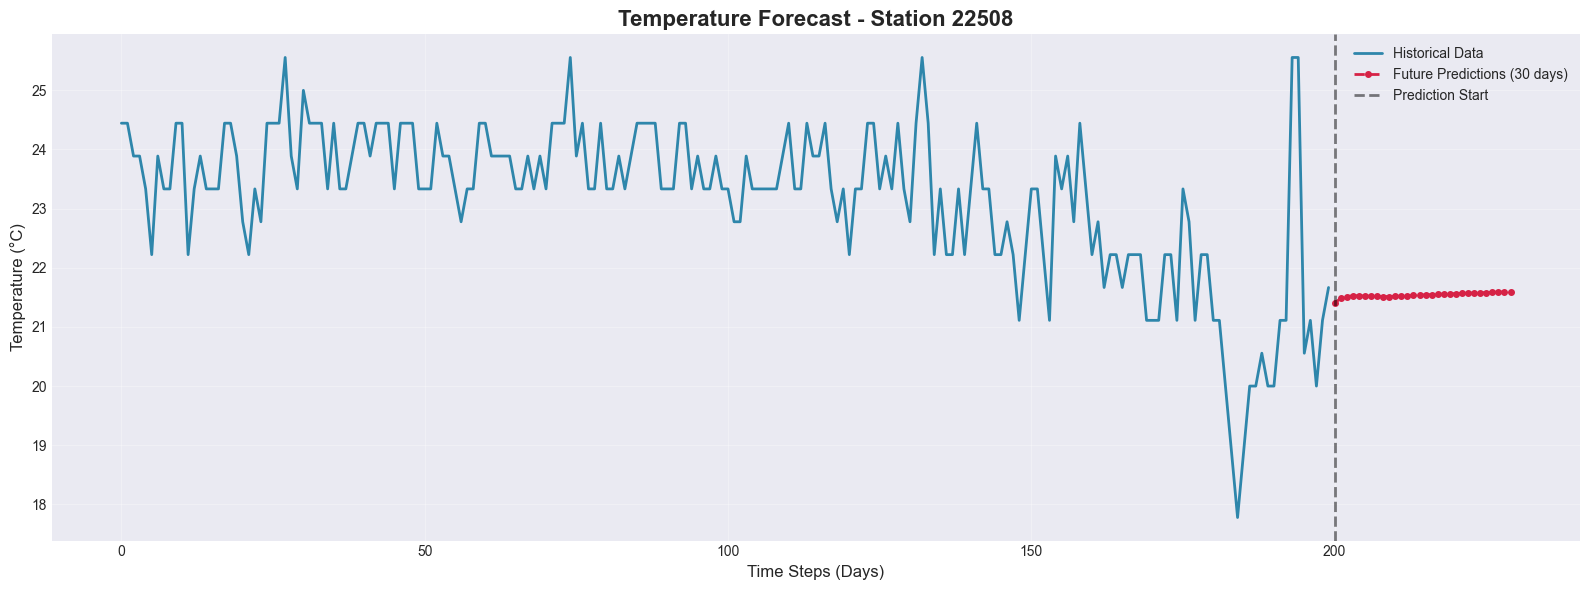


✅ Future 30 predictions generated successfully for Station 22508!
📊 Predicted temperature range: 21.40°C to 21.59°C
📊 Mean predicted temperature: 21.54°C


In [53]:
def predict_future(model: Sequential, last_sequence: np.ndarray, 
                   scaler: MinMaxScaler, n_steps: int = 30) -> np.ndarray:
    """
    Predict future temperature values.
    
    Args:
        model: Trained LSTM model
        last_sequence: Last sequence of data to start prediction
        scaler: Fitted MinMaxScaler
        n_steps: Number of future steps to predict
        
    Returns:
        Array of future predictions
    """
    future_predictions: List[float] = []
    current_sequence: np.ndarray = last_sequence.copy()
    
    for _ in range(n_steps):
        # Predict next value
        next_pred: np.ndarray = model.predict(current_sequence.reshape(1, lookback, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])
        
        # Update sequence (sliding window)
        current_sequence = np.append(current_sequence[1:], next_pred[0, 0])
    
    # Inverse transform predictions
    future_predictions_array: np.ndarray = np.array(future_predictions).reshape(-1, 1)
    future_predictions_original: np.ndarray = scaler.inverse_transform(future_predictions_array)
    
    return future_predictions_original

# Get last sequence from test data
last_sequence: np.ndarray = temperature_scaled[-(lookback):].flatten()

# Predict next 30 time steps
future_steps: int = 30
print(f"🔮 Generating {future_steps} days of future temperature predictions for Station {selected_station}...")
future_predictions: np.ndarray = predict_future(model, last_sequence, scaler, future_steps)

# Visualize future predictions
plt.figure(figsize=(16, 6))

# Plot historical data (last 200 points)
historical_data: np.ndarray = temperature_data[-200:]
plt.plot(range(len(historical_data)), historical_data, 
         label='Historical Data', color='#2E86AB', linewidth=2)

# Plot future predictions
future_x: np.ndarray = np.arange(len(historical_data), len(historical_data) + future_steps)
plt.plot(future_x, future_predictions, 
         label=f'Future Predictions ({future_steps} days)', 
         color='#D62246', linewidth=2, linestyle='--', marker='o', markersize=4)

plt.axvline(x=len(historical_data), color='black', linestyle='--', 
            linewidth=2, label='Prediction Start', alpha=0.5)

plt.title(f'Temperature Forecast - Station {selected_station}', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Future {future_steps} predictions generated successfully for Station {selected_station}!")
print(f"📊 Predicted temperature range: {future_predictions.min():.2f}°C to {future_predictions.max():.2f}°C")
print(f"📊 Mean predicted temperature: {future_predictions.mean():.2f}°C")

## Conclusion

### ✅ What We Accomplished:

1. **Station-Specific Analysis**
   - Loaded weather data with station identifiers (STA column)
   - Selected station with most records for analysis
   - Preprocessed data specific to the selected station

2. **Data Loading & Preprocessing**
   - Loaded weather data from `Summary of Weather.csv`
   - Handled missing values and sorted by date
   - Normalized data for LSTM training

3. **Model Development**
   - Built a 2-layer LSTM architecture with dropout regularization
   - Used 60-day lookback window for predictions
   - Implemented early stopping and model checkpointing

4. **Model Evaluation**
   - Calculated comprehensive metrics: MSE, RMSE, MAE, R² Score, MAPE
   - Analyzed residuals and error distributions
   - Visualized predictions vs actual values

5. **Future Predictions**
   - Generated 30-day temperature forecasts
   - Visualized historical data with future predictions

6. **Station-Specific Outputs**
   - All saved files include station ID in filename
   - Metrics and predictions are station-specific

### 🎯 Key Features:
- **Station Identification**: STA column used as identifier throughout analysis
- **Flexible Station Selection**: Auto-select largest dataset or specify station ID
- **Station-Specific Models**: Separate models can be trained for each station
- **Comprehensive Tracking**: All outputs labeled with station ID

### 🚀 Next Steps for Multi-Station Analysis:

1. **Train Models for Multiple Stations**
   - Loop through all unique stations
   - Train separate LSTM model for each station
   - Compare performance across stations

2. **Cross-Station Analysis**
   - Compare temperature patterns between stations
   - Identify geographical or temporal similarities
   - Build ensemble models combining multiple stations

3. **Transfer Learning**
   - Use model trained on one station as starting point for another
   - Fine-tune for station-specific characteristics

4. **Multi-Station Prediction**
   - Build unified model that takes station ID as input feature
   - Predict temperatures for any station in the dataset

### 📚 Resources:
- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Time Series Forecasting with Deep Learning](https://www.tensorflow.org/tutorials/structured_data/time_series)
- [Keras LSTM Documentation](https://keras.io/api/layers/recurrent_layers/lstm/)